# **Библиотеки**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### **settings**

In [39]:
plt.style.use('default')

# **Класс Decision Tree regressor**

### **Класс Node**

In [40]:
class Node():
    def __init__(self, current_feature=None, threshold=None, left=None, right=None, information_gain=None, value=None):
        
        self.current_feature = current_feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.information_gain = information_gain
        
        self.value = value

### **Decision Tree regressor**

In [41]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    
    def build_tree(self, data, current_depth=0):
        X, y = data[:, :-1], data[:, -1]

        num_samples, num_features = np.shape(X)
        best_split = {}

        if num_samples >= self.min_samples_split and current_depth <= self.max_depth:
            best_split = self.get_best_split(data, num_samples, num_features)
            
            if best_split != {}:
              if best_split["information_gain"] > 0:
                  left_subtree = self.build_tree(best_split['data_left'], current_depth + 1)
                  right_subtree = self.build_tree(best_split['data_right'], current_depth + 1)

                  return Node(best_split["current_feature"], best_split["threshold"], 
                              left_subtree, right_subtree, best_split["threshold"])
        
        leaf_value = np.mean(y)
        return Node(value=leaf_value)

    def get_best_split(self, data, num_samples, num_features):
        best_split = {}
        max_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = data[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            for threshold in possible_thresholds:

                data_left, data_right = self.split(data, feature_index, threshold)
                if len(data_left) > 0 and len(data_right) > 0:
                    y, y_left, y_right = data[:, -1], data_left[:, -1], data_right[:, -1]
                    current_gain = self.compute_information_gain(y, y_left, y_right)
                    if current_gain > max_gain:
                        best_split["current_feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["data_left"] = data_left
                        best_split["data_right"] = data_right
                        best_split["information_gain"] = current_gain
                        max_gain = current_gain

        return best_split    


    def split(self, data, current_feature, threshold):
        data_left = np.array([row for row in data if row[current_feature] <= threshold])
        data_right = np.array([row for row in data if row[current_feature] > threshold])
        return data_left, data_right

    def compute_information_gain(self, parent, left_child, right_child):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)

        parent = self.MSE(parent)
        left_child = self.MSE(left_child)
        right_child = self.MSE(right_child)
        inf_gain = parent - weight_left * left_child - weight_right * right_child

        return inf_gain
        
    def MSE(self, y):
        average_y = y.mean()
        sum = 0
        for i in range(len(y)):
            sum += (y[i] - average_y) ** 2 / len(y)
        
        return sum

    def fit(self, X, y):
        data = np.concatenate((X, y), axis=1)
        self.root = self.build_tree(data)

    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.current_feature]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

# **Functions**

In [42]:
def to_np_array(array):
    return np.array(array)

def give_samples(n, a, b):
    X = []
    y = []
    for i in range(n):
        x = np.random.uniform(a, b)
        X.append([x])
        y.append([x * np.sin(x)])

    return X, y

def give_samples_with_noise(n, a, b):
    X = []
    y = []
    for i in range(n):
        x = np.random.uniform(a, b)
        X.append([x])
        y.append([x * np.sin(x) + np.random.normal(0, 2)])

    return X, y

def to_array(array, n):
    arr = []
    for i in range(n):
        arr.append(array[i][0])
    return arr

def ndarray_sort(array, n):
    arr = to_array(array, n)
    array = []
    arr = np.sort(arr)
    for i in range(n):
        array.append([arr[i]])
    return array

def randomShuffle(X, y):
    X_shuffle = []
    y_shuffle = []
    for i in range(35):
        rnd = np.random.randint(0, 500)
        X_shuffle.append(X[rnd])
        y_shuffle.append(y[rnd])
    return X_shuffle, y_shuffle

# **Decision tree enseble - Bagging**

## **Обучим 100 раз деревья решений на 35 рандомных семплах двумя способами**

In [43]:
treeRegressorEnsemble = DecisionTreeRegressor(min_samples_split=1, max_depth=7)

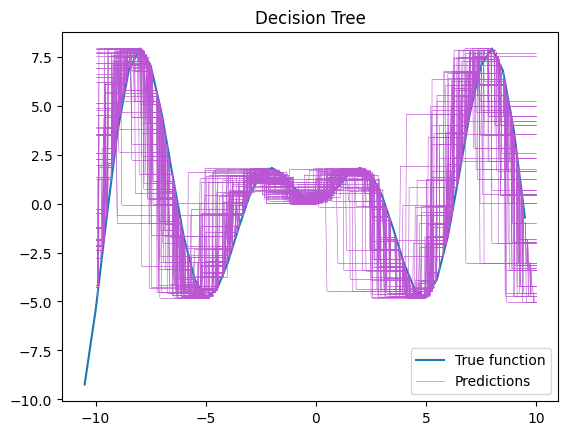

In [44]:
X_real = []
y_real = []
for i in range(-10, 10, 1):
    X_real.append(i - 0.5)
    X_real.append(i)
    X_real.append(i + 0.5)

    y_real.append((i - 0.5) * np.sin(i - 0.5))
    y_real.append(i * np.sin(i))
    y_real.append((i + 0.5) * np.sin(i + 0.5))

plt.plot(X_real, y_real, label = 'True function')

pred = [0] * 100

X_train, y_train = give_samples(500, -10, 10)

X_test, y_test = give_samples(1000, -10, 10)

X_test = ndarray_sort(X_test, 1000)

for i in range(100):
    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressorEnsemble.fit(X_ens, y_ens)

    y_pred = treeRegressorEnsemble.predict(X_test)
    for k in range(999):
        a = X_test[k]
        b = y_pred[k]
        c = X_test[k + 1]
        d = y_pred[k + 1]
        if i == 99 and k == 998:
            plt.plot([a, c], [b, d], 'mediumorchid', lw = 0.4,
                     label = 'Predictions')
        else:
            plt.plot([a, c], [b, d], 'mediumorchid', lw = 0.4)

plt.title('Decision Tree')
plt.legend()
plt.show()

## **Непосредственно Bagging**

### **Можно было 10 раз обучить одну и туже модель в for, но для наглядности создадим 10 моделей**

In [45]:
treeRegressor1 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor2 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor3 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor4 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor5 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor6 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor7 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor8 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor9 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)
treeRegressor10 = DecisionTreeRegressor(min_samples_split=1, max_depth=7)

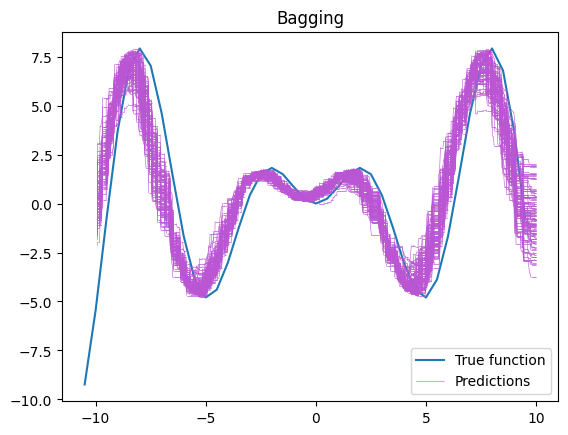

In [46]:
X_real = []
y_real = []
for i in range(-10, 10, 1):
    X_real.append(i - 0.5)
    X_real.append(i)
    X_real.append(i + 0.5)

    y_real.append((i - 0.5) * np.sin(i - 0.5))
    y_real.append(i * np.sin(i))
    y_real.append((i + 0.5) * np.sin(i + 0.5))
plt.plot(X_real, y_real, label = 'True function')

pred = [0] * 100

X_train, y_train = give_samples(500, -10, 10)
X_test, y_test = give_samples(1000, -10, 10)
X_test = ndarray_sort(X_test, 1000)

for i in range(100):
    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor1.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor2.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor3.fit(X_ens, y_ens)
    
    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor4.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor5.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor6.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor7.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor8.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor9.fit(X_ens, y_ens)

    X_ens, y_ens = randomShuffle(X_train, y_train)
    treeRegressor10.fit(X_ens, y_ens)

    y_pred1 = treeRegressor1.predict(X_test)
    y_pred2 = treeRegressor2.predict(X_test)
    y_pred3 = treeRegressor3.predict(X_test)
    y_pred4 = treeRegressor4.predict(X_test)
    y_pred5 = treeRegressor5.predict(X_test)
    y_pred6 = treeRegressor6.predict(X_test)
    y_pred7 = treeRegressor7.predict(X_test)
    y_pred8 = treeRegressor8.predict(X_test)
    y_pred9 = treeRegressor9.predict(X_test)
    y_pred10 = treeRegressor10.predict(X_test)

    pred = [0] * 1000
    for p in range(1000):
        pred[p] = pred[p] + y_pred1[p] + y_pred2[p] + y_pred3[p] +  y_pred4[p] + y_pred5[p] + y_pred6[p] + y_pred7[p] + y_pred8[p] + y_pred9[p] + y_pred10[p]
    for p in range(1000):
        pred[p] = pred[p] / 10

    for k in range(999):
        a = X_test[k]
        b = pred[k]
        c = X_test[k + 1]
        d = pred[k + 1]
        if i == 99 and k == 998:
            plt.plot([a, c], [b, d], 'mediumorchid', lw = 0.4,
                     label = 'Predictions')        
        else:
            plt.plot([a, c], [b, d], 'mediumorchid', lw = 0.4)

plt.title('Bagging')
plt.legend()
plt.show()

# **Result**

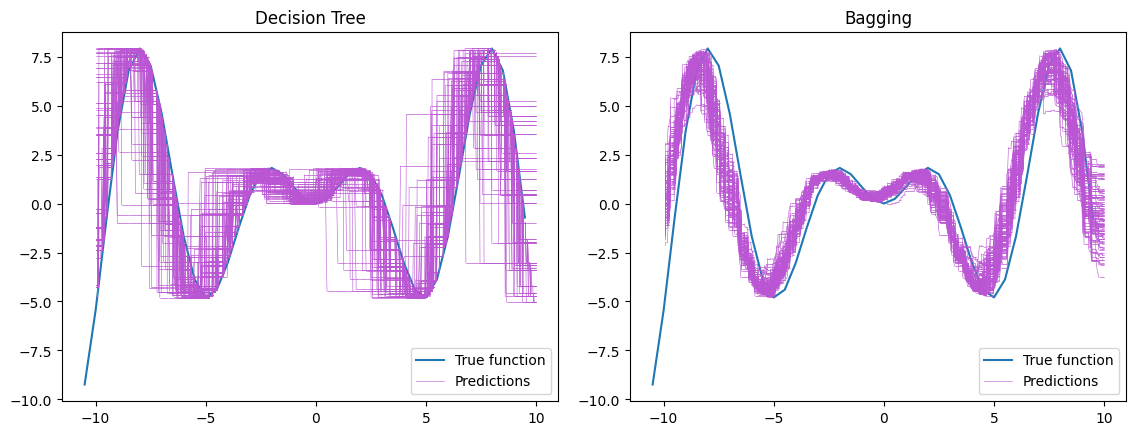